**Import packages**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Problem 1

## P1.1: Network building and implementation

**Read data and pre-processing**

In [4]:
df1 = pd.read_csv('gdrive/My Drive/Colab Notebooks/train-1.csv', header=None)
df2 = pd.read_csv('gdrive/My Drive/Colab Notebooks/test-1.csv', header=None)
X, y = df1.values[:, :-1], df1.values[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
n_features = X_train.shape[1]

X_test, y_test = df2.values[:, :-1], df2.values[:, -1]

**Neural network architecture**

In the following I will use the [functional API](https://www.tensorflow.org/guide/keras/functional) to build the architecture. I define a Customlayer here to achieve the functionality that $\phi$ layer does, where for some d-dimensional input, split it into d slices and treat each slice as the input for neural network $\phi$, and then sum them up, followed by a $\rho$ network. 

**$\phi$-layer**: The original input has 10 features, for each feature process it with $\phi$-network, say $\phi(x_i)$, this should give an output of dimension same as latent space (lat_dim). So $(\sum_{x\in X}\phi(x))\in R^d$ where $d$ denotes the latent dimension. 

**$\rho$-layer**: Takes the output from the $\phi$-layer as input and process like ordinary dense layer.

In [6]:
def get_phi(lat_dim, activation):
  #build the dense phi network 
    phi_input = keras.Input(shape=(1,))#element in each data point, is a scalar in this case.
    phi_hidden = layers.Dense(100, activation=activation, kernel_initializer="random_normal")(phi_input)
    phi_output = layers.Dense(lat_dim)(phi_hidden)
    return keras.Model(inputs=phi_input, outputs=phi_output)

class Customlayer(tf.keras.Model):
  def __init__(self, lat_dim, activation):
    super().__init__()
    self.phi = get_phi(lat_dim, activation)

  def call(self, inputs):
    l = []
    a = tf.reshape(inputs, (-1,10,1))#for following slicing
    for i in range(10): #n_features=10
      l.append(self.phi(a[:,i]))#slicing to process each element over phi network
    return tf.reduce_sum(l, axis=0)#returns mapping by phi

def get_model(lat_dim=5, activation="relu"):
  input = keras.Input(shape=(n_features, ), name="input")
  rho_input = Customlayer(lat_dim, activation)(input)
  rho_hidden = layers.Dense(100, activation=activation, kernel_initializer="random_normal", name="rho_hidden")(rho_input)
  rho_output = layers.Dense(1, name="output")(rho_hidden)
  model = keras.Model(input, rho_output, name="phi_rho_network")
  return model

In [98]:
model = get_model()
model.summary() #parameters of the network

Model: "phi_rho_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10)]              0         
                                                                 
 customlayer (Customlayer)   (None, 5)                 705       
                                                                 
 rho_hidden (Dense)          (None, 100)               600       
                                                                 
 output (Dense)              (None, 1)                 101       
                                                                 
Total params: 1,406
Trainable params: 1,406
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4), loss="mse", metrics=["mse"])

**Validation of invariant functionality**

Since we aim to learn the sum-decomposable function, the entire neural network should be permutation invariant, I will check this here. And it is easy to find that the results are invariant for any random permutations.




In [7]:
t1 = np.random.choice(np.arange(10), 10, replace=False).astype("float64")
t2 = np.random.choice(np.arange(10), 10, replace=False).astype("float64")
t1, t2

(array([7., 1., 8., 0., 3., 5., 2., 4., 9., 6.]),
 array([6., 8., 2., 0., 4., 1., 9., 5., 7., 3.]))

In [13]:
a = model.predict([list(t1)])
b = model.predict([list(t2)])
print(f"The first sample:{a[0]}")
print(f"The second sample:{b[0]}")

The first sample:[0.26840124]
The second sample:[0.26840124]


## P1.2: Training and evaluation

Training the two models with different latent dimensions.

In [16]:
model_5 = get_model(5)
model_5.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4), loss="mse", metrics=["mse"])
model_100 = get_model(100)
model_100.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4), loss="mse", metrics=["mse"])

hs_5 = model_5.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0, validation_data = (X_val, y_val))
hs_100 = model_100.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0, validation_data = (X_val, y_val))

Plot the MSE losses against epoch numbers for the two models

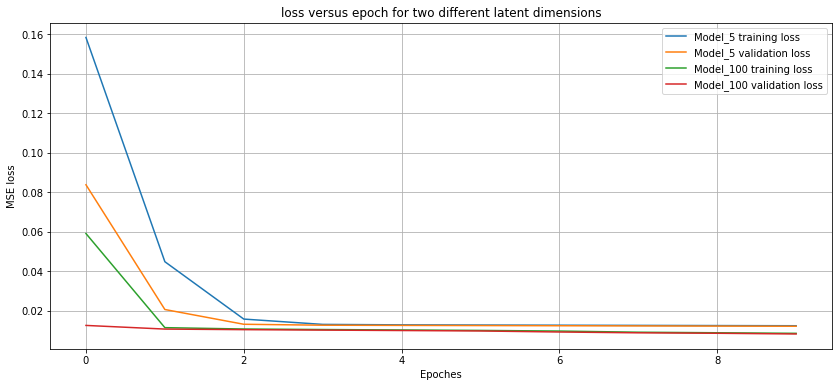

In [17]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(hs_5.history["loss"], label="Model_5 training loss")
ax.plot(hs_5.history["val_loss"], label="Model_5 validation loss")
ax.plot(hs_100.history["loss"], label="Model_100 training loss")
ax.plot(hs_100.history["val_loss"], label="Model_100 validation loss")

ax.set_title("loss versus epoch for two different latent dimensions")
ax.legend()
ax.grid()
ax.set_ylabel("MSE loss")
ax.set_xlabel("Epoches")
plt.show()

In [18]:
MSE_model_5 = np.square(model_5.predict(X_test) - y_test).mean()
MSE_model_100 = np.square(model_100.predict(X_test) - y_test).mean()
print(f"Test MSE for model_5: {MSE_model_5}")
print(f"Test MSE for model_100: {MSE_model_100}")

Test MSE for model_5: 0.020124246391818895
Test MSE for model_100: 0.022213752047713132


Apparently, the network with 100 dimensional latent space has much lower training and validation loss compared to 5 dimensional one. Also the training and validation loss of 100-D model seems to converge to a lower level. However, the test MSE of the 100-D model is larger than that of 5-D model. The 100-D model may overfit the data, with much larger amount of parameters compared to 5-D model.

## P1.3: Choice of learning rate

Try learning rates [0.01, 0.1, 0.5]

In [99]:
model_1 = get_model(100)
model_1.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss="mse", metrics=["mse"])
hs_1 = model_1.fit(X_train, y_train, epochs=10, batch_size=128, verbose=2, validation_data = (X_val, y_val))

Epoch 1/10
704/704 - 5s - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0044 - val_mse: 0.0044 - 5s/epoch - 7ms/step
Epoch 2/10
704/704 - 4s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0035 - val_mse: 0.0035 - 4s/epoch - 5ms/step
Epoch 3/10
704/704 - 3s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0033 - val_mse: 0.0033 - 3s/epoch - 5ms/step
Epoch 4/10
704/704 - 3s - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0033 - val_mse: 0.0033 - 3s/epoch - 5ms/step
Epoch 5/10
704/704 - 3s - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0039 - val_mse: 0.0039 - 3s/epoch - 5ms/step
Epoch 6/10
704/704 - 4s - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0032 - val_mse: 0.0032 - 4s/epoch - 5ms/step
Epoch 7/10
704/704 - 3s - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0033 - val_mse: 0.0033 - 3s/epoch - 5ms/step
Epoch 8/10
704/704 - 3s - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0032 - val_mse: 0.0032 - 3s/epoch - 5ms/step
Epoch 9/10
704/704 - 4s - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0033 - val_mse: 0.0033 - 4s/epoch - 5

In [103]:
model_2 = get_model(100)
model_2.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1), loss="mse", metrics=["mse"])
hs_2 = model_2.fit(X_train, y_train, epochs=10, batch_size=128, verbose=2, validation_data = (X_val, y_val))

Epoch 1/10
704/704 - 6s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 6s/epoch - 8ms/step
Epoch 2/10
704/704 - 6s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 6s/epoch - 8ms/step
Epoch 3/10
704/704 - 6s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 6s/epoch - 8ms/step
Epoch 4/10
704/704 - 5s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 5s/epoch - 8ms/step
Epoch 5/10
704/704 - 6s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 6s/epoch - 8ms/step
Epoch 6/10
704/704 - 3s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 3s/epoch - 5ms/step
Epoch 7/10
704/704 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 5ms/step
Epoch 8/10
704/704 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 5ms/step
Epoch 9/10
704/704 - 3s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 3s/epoch - 5ms/step
Epoch 10/10
704/704 - 3s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 3s/epoch - 5ms/step

In [46]:
model_3 = get_model(100)
model_3.compile(optimizer=keras.optimizers.SGD(learning_rate=0.5), loss="mse", metrics=["mse"])
hs_3 = model_3.fit(X_train, y_train, epochs=10, batch_size=128, verbose=2, validation_data = (X_val, y_val))

Epoch 1/10
704/704 - 5s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 5s/epoch - 7ms/step
Epoch 2/10
704/704 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 5ms/step
Epoch 3/10
704/704 - 3s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 3s/epoch - 5ms/step
Epoch 4/10
704/704 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 5ms/step
Epoch 5/10
704/704 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 5ms/step
Epoch 6/10
704/704 - 3s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 3s/epoch - 5ms/step
Epoch 7/10
704/704 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 5ms/step
Epoch 8/10
704/704 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 5ms/step
Epoch 9/10
704/704 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 5ms/step
Epoch 10/10
704/704 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 5ms/step

**Adaptive learning rate**

As we can see that constant learning rates 0.1 and 0.5 lead to nan values, since they are too large so that gradient explodes. Hence it is essential to control the step size, we can put into use of adapative optimiser instead of using SGD with constant learning rate, this will ensure that update does not explode. In the following I will use Adam with three required learning rates and compare the results. 

In [8]:
lr = [0.01, 0.1, 0.5]
model_hs = []
MSE = []
for i in lr:
  model_1 = get_model(100)
  model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse", metrics=["mse"])
  hs_1 = model_1.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0, validation_data = (X_val, y_val))
  model_hs.append(hs_1)
  test_mse = np.square(model_1.predict(X_test) - y_test).mean()
  MSE.append(test_mse)

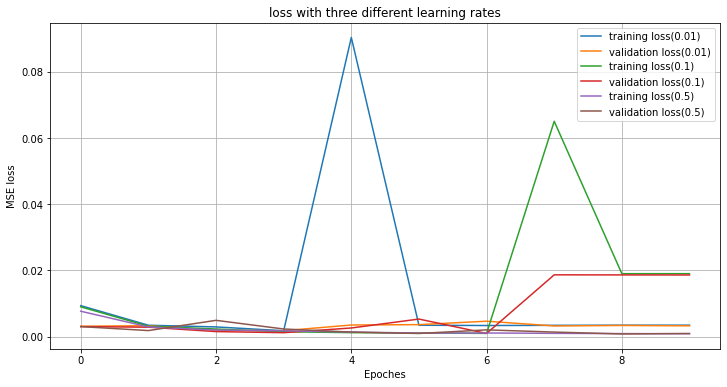

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
for i in range(3):
  ax.plot(model_hs[i].history["loss"], label=f"training loss({lr[i]})")
  ax.plot(model_hs[i].history["val_loss"], label=f"validation loss({lr[i]})")
ax.set_title("loss with three different learning rates")
ax.set_xlabel("Epoches")
ax.set_ylabel("MSE loss")
ax.grid()
ax.legend()
plt.show()

In [15]:
print(f"Test mse for learning rate 0.01: {MSE[0]}")
print(f"Test mse for learning rate 0.1: {MSE[1]}")
print(f"Test mse for learning rate 0.5: {MSE[2]}")

Test mse for learning rate 0.01: 0.034809858958443435
Test mse for learning rate 0.1: 0.01914127803031997
Test mse for learning rate 0.5: 0.03801169702078114


We can find that although learning rate 0.5 has the lowest training and validation loss, but the highest test error. 0.1 has the smallest test error. This is reasonable since the learning rate should be at an intermediate level. Too small rate would lead to stuck in the local minimum and too large value would overshoot.

## P1.4: Choice of activation function

In [ ]:
model_relu = get_model(100)
model_relu.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4), loss="mse", metrics=["mse"])
hs_relu = model_relu.fit(X_train, y_train, epochs=50, batch_size=128, verbose=2, validation_data = (X_val, y_val))

In [ ]:
model_sigmoid = get_model(100, "sigmoid")
model_sigmoid.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4), loss="mse", metrics=["mse"])
hs_sigmoid = model_sigmoid.fit(X_train, y_train, epochs=50, batch_size=128, verbose=2, validation_data = (X_val, y_val))

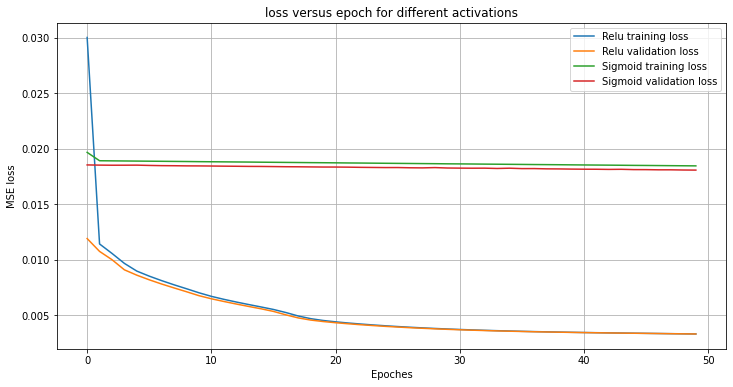

In [23]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(hs_relu.history["loss"], label="Relu training loss")
ax.plot(hs_relu.history["val_loss"], label="Relu validation loss")

ax.plot(hs_sigmoid.history["loss"], label="Sigmoid training loss")
ax.plot(hs_sigmoid.history["val_loss"], label="Sigmoid validation loss")
ax.set_title("loss versus epoch for different activations")
ax.legend()
ax.grid()

ax.set_xlabel("Epoches")
ax.set_ylabel("MSE loss")
plt.show()

In [24]:
tmse_relu = np.square(model_relu.predict(X_test) - y_test).mean()
tmse_sigmoid = np.square(model_sigmoid.predict(X_test) - y_test).mean()
print(f"Test mse for ReLU: {tmse_relu}")
print(f"Test mse for Sigmoid: {tmse_sigmoid}")

Test mse for ReLU: 0.03328472773683616
Test mse for Sigmoid: 0.019145420495418976


ReLU activation has much lower training and validation error, but Sigmoid activation has lower test error. One possible reason that Sigmoid suffers higher level of loss during training may due to the vanishing gradient, so we can see that training and validation loss almost keep still. Althpugh ReLU can decrease the loss into a much lower level, but it seems the model overfits the data, leading to a higher test error.

## P1.5: Comparison of neural networks

I just noticed only 20 latent dimension values are required to try after I have tried 100 values. So I will keep the plot with 100 latent dimension values and it actually provides more information.

In [16]:
vec = np.zeros(100) #initialise a vector containing mean test MSE for each lat_dim
for lat_dim in np.arange(1,101):
  mse = 0.
  for i in np.arange(5): #5 individual training runs
    model = get_model(lat_dim) # define the corresponding model
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4), loss="mse", metrics=["mse"])

    checkpoint_filepath = '/temp/min_val' #callback path
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True, #save the bset weight and model
    monitor='val_loss', # decide which model to be the best model based on validation loss
    mode='min', # choose the one with the minimum validation loss
    save_best_only=True) #save only the best model

    history = model.fit(X_train, y_train, epochs=5, batch_size=128, verbose=0, callbacks=[model_checkpoint_callback], validation_data = (X_val, y_val))
    model.load_weights(checkpoint_filepath) #load trained weights of the best model to the current model

    test_mse = np.square(model.predict(X_test) - y_test).mean() #calculate the test MSE with the above model
    mse += test_mse
  vec[lat_dim-1] = mse/5.

In [17]:
vec

array([0.02630001, 0.02280073, 0.02696893, 0.01972039, 0.02020942,
       0.01984714, 0.01982808, 0.01973757, 0.01984297, 0.01982379,
       0.02019743, 0.02019495, 0.01992618, 0.02026494, 0.02002657,
       0.02010131, 0.02036916, 0.01987629, 0.02047136, 0.02033483,
       0.02057543, 0.02029892, 0.02027705, 0.02026295, 0.02043203,
       0.02063716, 0.02075996, 0.02084055, 0.0205878 , 0.02063442,
       0.02079818, 0.02032341, 0.02107211, 0.02054855, 0.02077544,
       0.02063107, 0.02083847, 0.02066151, 0.02062548, 0.02094661,
       0.02049665, 0.02126264, 0.02113299, 0.02109329, 0.02070369,
       0.02073304, 0.02084234, 0.02094195, 0.02055084, 0.02124696,
       0.02073503, 0.02123636, 0.02160681, 0.02138908, 0.02081033,
       0.02060981, 0.02176563, 0.02134179, 0.02096212, 0.02091146,
       0.02176223, 0.0209885 , 0.02097931, 0.02112847, 0.02216427,
       0.02060317, 0.02129055, 0.02107398, 0.02143915, 0.02118415,
       0.02149755, 0.02126908, 0.02092345, 0.02152199, 0.02157

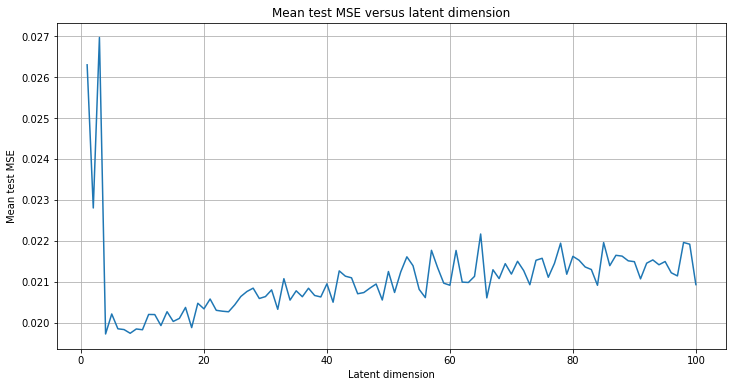

In [21]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(1,101), vec)
ax.set_title("Mean test MSE versus latent dimension")
ax.set_xlabel("Latent dimension")
ax.set_ylabel("Mean test MSE")
ax.grid()
plt.show()

Clearly, the mean test MSE first decreases sharply when latent dimension reaching 4, and then fluctuates as latent dimension increases. We can only observe trivial difference between proper value of latent dimension (10) and those larger values (more than 50). And latent dimension with around 10 has the lowest test error. Model with too fewer latent dimensions may lack the ability to fit the data, with a large number of latent dimensions may overfit the data. This is as expected, since any continuous function $f:R^m \rightarrow R$ is permutation invariant if it is sum-decomposable via $R^{\geq m}$. The data used here is $R^{10}$, so lat_dim=10 may be the optimal latent dimension.

#Problem 2

**Data pre-processing**

In [5]:
xtrain = pd.read_csv('gdrive/My Drive/Colab Notebooks/xtrain-2.csv', header=None)[1:]
ytrain = pd.read_csv('gdrive/My Drive/Colab Notebooks/ytrain-2.csv', header=None)[1:]
xtest = pd.read_csv('gdrive/My Drive/Colab Notebooks/xtest-2.csv', header=None)[1:]
ytest = pd.read_csv('gdrive/My Drive/Colab Notebooks/ytest-2.csv', header=None)[1:]

xtrain = xtrain.values[:,1:].reshape(-1,5,3)
ytrain = ytrain.values[:,1:].reshape(-1,5,1)
X_train, X_val, y_train, y_val = train_test_split(xtrain, ytrain, test_size=0.1)

xtest = xtest.values[:,1:].reshape(-1,5,3)
ytest = ytest.values[:,1:].reshape(-1,5,1)

##P2.1: Equivariant neural network implementation

In this part I construct an EquiLayer that does affine equivariant transformations, each layer represents a linear mapping where the order of results matches the order of the input. An equivariant neural network then consists of L EquiLayers where the outputs of the first L-1 layers are processed by activation function and output of the L-th layer directly connects the final output layer. Each EquiLayer is defined as:
$$f_l(X):R^{m\times d_{l-1}}\rightarrow R^{m\times d_l}=XA_l + \frac{1}{m}11^TXB_l+1c_l^T$$
where $A_l\in R^{d_{l-1}\times d_l}, B_l\in R^{d_{l-1}\times d_l}, c_l \in R^{d_l}$. In our case, the input is $R^{5\times 3}$ which means 5 features, each feature is 3-D. After feeding into the neural network, the output should be in $R^{5\times 1}$.

In [6]:
class EquiLayer(tf.keras.layers.Layer):
    def __init__(self, w_shape):
        super().__init__()
        self.w_shape = w_shape #w here is d_l. As required keep it the same for each hidden layer.
    
    def build(self, input_shape):
        self.A = self.add_weight(  #build matrix A
            "weights_A",
            shape=(int(input_shape[-1]), self.w_shape),
            initializer=tf.keras.initializers.RandomNormal(),
        )
        self.B = self.add_weight(  #build matrix B
            "weights_B",
            shape=(int(input_shape[-1]), self.w_shape),
            initializer=tf.keras.initializers.RandomNormal(),
        )
        self.C = self.add_weight(  #build vector c
            "weights_C",
            shape=(self.w_shape, ),
            initializer=tf.keras.initializers.RandomNormal(),
        )

    def call(self, inputs): #matric calculation, fully connected between layers.
        x1 = tf.matmul(inputs, self.A)
        x2 = tf.matmul(inputs, self.B)
        m = inputs.shape[1]
        ones = tf.ones([m, m])
        x3 = tf.tensordot(tf.ones([m]), self.C, axes=0)
        return (x1 + 1/m*tf.matmul(ones, x2) + x3)

def get_eqmodel(L=2, w=5): # a function that returns network with L hidden layers and dimension w=5 for each layer.
  input = keras.Input(shape=(5,3), name="input_layer")
  Equi1 = keras.activations.relu(EquiLayer(w)(input))
  for i in range(L-2): #subsequent layers that need activation transformation
    Equi1 = keras.activations.relu(EquiLayer(w)(Equi1))
  EquiL = EquiLayer(w)(Equi1) #the L-th layer
  output = EquiLayer(1)(EquiL) #output layer
  model_eq = keras.Model(input, output, name="output_layer")
  return model_eq

In [78]:
model_eq = get_eqmodel()
model_eq.summary()

Model: "output_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 5, 3)]            0         
                                                                 
 equi_layer_39 (EquiLayer)   (None, 5, 5)              35        
                                                                 
 tf.nn.relu_17 (TFOpLambda)  (None, 5, 5)              0         
                                                                 
 equi_layer_40 (EquiLayer)   (None, 5, 5)              55        
                                                                 
 equi_layer_41 (EquiLayer)   (None, 5, 1)              11        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


**Validation for equivariant functionality**

To validate the correctness of the neural network architecture, put one data input and its permutated version, if the predictions match this permutation then it is equivariant.

In [119]:
a = xtrain[0]
order = np.random.permutation(np.arange(5))
b = a[order] #b is a permutation of a

In [121]:
pred_a = model_eq.predict(tf.reshape(a, shape=(-1,5,3)))
pred_a = np.squeeze(pred_a, axis=0) # prediction of a by the network
pred_b = model_eq.predict(tf.reshape(b, shape=(-1,5,3)))
pred_b = np.squeeze(pred_b, axis=0) #prediction of b by the network

In [122]:
print(f"prediction for a:\n{pred_a}")
print(f"prediction for b:\n{pred_b}")
print(f"Equivariant is: \n{pred_a[order]==pred_b}") #check if the permutation works on predictions or not.

prediction for a:
[[0.06783666]
 [0.0677218 ]
 [0.06790473]
 [0.06790733]
 [0.06791326]]
prediction for b:
[[0.06783666]
 [0.06791326]
 [0.06790473]
 [0.0677218 ]
 [0.06790733]]
Equivariant is: 
[[ True]
 [ True]
 [ True]
 [ True]
 [ True]]


##P2.2: Training&Evaluation for networks with different architectures

In [56]:
L_w = [(2,5), (2,10), (2,100), (2,200), (3,5), (3,10), (3,100), (3,200)]
hashm = {lw:[] for lw in L_w}
MSE = {lw:0 for lw in L_w}
for lw in L_w:
  L = lw[0]
  w = lw[1]
  model_eq = get_eqmodel(L,w)
  model_eq.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-3), loss="mse", metrics=["mse"])
  hs_eq = model_eq.fit(X_train, y_train, epochs=100, batch_size=300, verbose=0, validation_data = (X_val, y_val))
  test_mse = np.square(model.predict(xtest) - ytest).mean()
  MSE[lw] = test_mse
  hashm[lw].append(hs_eq.history["loss"])
  hashm[lw].append(hs_eq.history["val_loss"])

**Training&Validation loss analysis**

For a clear visulisation, I will produce two seperated plots based on the number of hidden layers. 

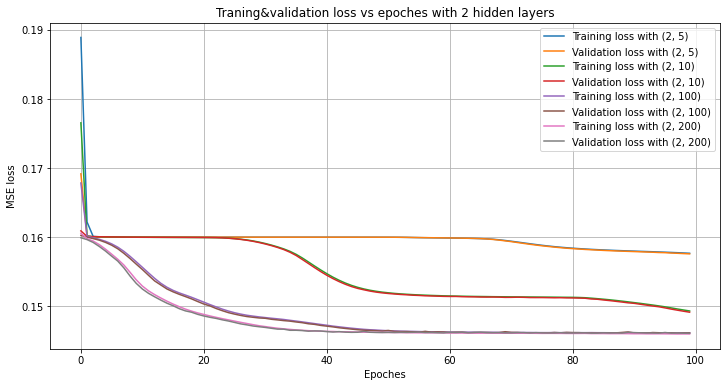

In [73]:
fig, ax = plt.subplots(figsize=(12,6))
for lw in L_w[:4]:
  ax.plot(hashm[lw][0], label=f"Training loss with {lw}")
  ax.plot(hashm[lw][1], label=f"Validation loss with {lw}")
ax.grid()
ax.legend(bbox_to_anchor=(1., 1.))
ax.set_title("Traning&validation loss vs epoches with 2 hidden layers")
ax.set_xlabel("Epoches")
ax.set_ylabel("MSE loss")
plt.show()

From the above figure we can find that models with larger $w$ tend to have lower losses and converge more quickly. Validation loss of the model with $w=5$ is stuck at loss=0.16 and starts to decrease after a lot more epoches, while models with $w\in\{100,200\}$ decrease at the very beginning stage. Also, the training loss for $w\in\{5,10\}$ start at a higher level. Since larger values of $(L,w)$ represent more parameters and higher model complexity, this may lead to overfitting and consume more computation.

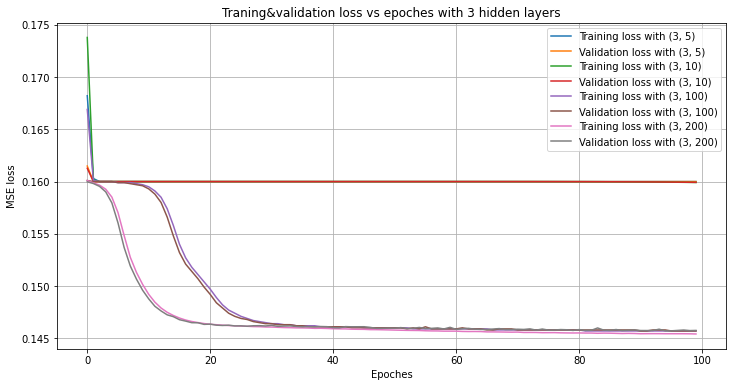

In [74]:
fig, ax = plt.subplots(figsize=(12,6))
for lw in L_w[4:]:
  ax.plot(hashm[lw][0], label=f"Training loss with {lw}")
  ax.plot(hashm[lw][1], label=f"Validation loss with {lw}")
ax.grid()
ax.set_title("Traning&validation loss vs epoches with 3 hidden layers")
ax.set_xlabel("Epoches")
ax.set_ylabel("MSE loss")
ax.legend(bbox_to_anchor=(1., 1.))
plt.show()

Models with 3 hidden layers have similar curves as that with 2 hidden layers. However, for $w\in \{5,10\}$, losses are stuck at the local minimum and are not able to decrease withing the 100 epoches. Losses with $w=100$ start to go down after around 10 epoches, while losses with $w=200$ decreases earlier and faster. But losses of the two models tend to converge to an identical level at around loss=0.147. 

**Testing MSE analysis**

In [84]:
MSE

{(2, 5): 0.15793624,
 (2, 10): 0.14876742,
 (2, 100): 0.14688974,
 (2, 200): 0.14639785,
 (3, 5): 0.15989842,
 (3, 10): 0.14843976,
 (3, 100): 0.14597807,
 (3, 200): 0.14579921}

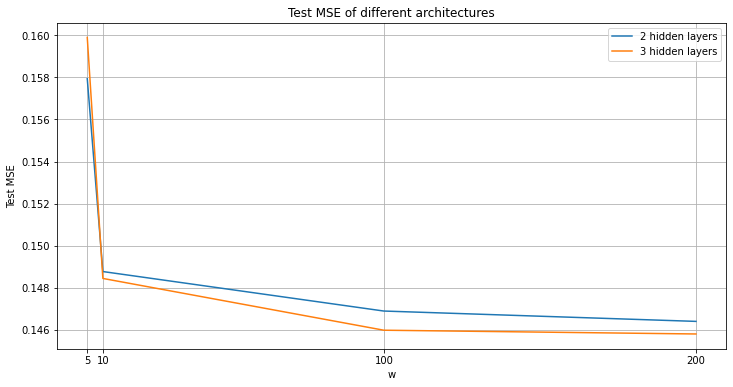

In [89]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot([5,10,100,200],L[:4], label="2 hidden layers")
ax.plot([5,10,100,200],L[4:], label="3 hidden layers")
ax.grid()

ax.set_title("Test MSE of different architectures")
ax.set_xlabel("w")
ax.set_ylabel("Test MSE")
ax.set_xticks([5,10,100,200])
ax.legend()
plt.show()

The test MSE decrease sharply when $w$ goes from 5 to 10, but only trivial loss deduction is witnessed for $w\in \{100,200\}$. This may tell that a very large $w$ may lead to overfitting, it is also computationally expensive.

**Conclusion:** Results are as expected, higher complexity means lower loss during training. But it seems 2-layer models can somewhat outperform 3-layer models when traning, while 3-layer models have lower test error. High magnitude of complexity may lead to overfitting.